In [2]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.data_causl import *
from frengression import *
device = torch.device('cpu')

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
# import src.exp_utils as exp_utils

from matplotlib import pyplot as plt


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True


# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

## when training size = 1000

In [ ]:
nrep = 10 # for equivalence testing
n_tr = 1000
n_p = 500
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 1.0188, loss1 1.0472, loss2 0.0569
Epoch 1: loss 2.2212,	loss_y 1.4487, 1.4669, 0.0363,	loss_eta 0.7725, 0.8145, 0.0839


 10%|█         | 1/10 [00:15<02:15, 15.07s/it]

Epoch 1: loss 0.9485, loss1 0.9871, loss2 0.0774
Epoch 1: loss 2.3143,	loss_y 1.5407, 1.5687, 0.0561,	loss_eta 0.7737, 0.8094, 0.0715


 20%|██        | 2/10 [00:29<01:58, 14.87s/it]

Epoch 1: loss 0.9391, loss1 0.9892, loss2 0.1001
Epoch 1: loss 2.2300,	loss_y 1.4690, 1.5006, 0.0632,	loss_eta 0.7609, 0.7844, 0.0469


## when training size = 500

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 0.9772, loss1 1.0075, loss2 0.0605
Epoch 100: loss 0.6843, loss1 1.4038, loss2 1.4388
Epoch 200: loss 0.6754, loss1 1.3528, loss2 1.3548
Epoch 300: loss 0.7000, loss1 1.3907, loss2 1.3815
Epoch 400: loss 0.6937, loss1 1.3725, loss2 1.3576
Epoch 500: loss 0.7155, loss1 1.3992, loss2 1.3673
Epoch 1: loss 2.2865,	loss_y 1.4999, 1.5470, 0.0943,	loss_eta 0.7866, 0.8311, 0.0889
Epoch 100: loss 1.3183,	loss_y 0.7410, 1.7188, 1.9557,	loss_eta 0.5774, 1.0804, 1.0060
Epoch 200: loss 1.2555,	loss_y 0.5769, 0.9888, 0.8239,	loss_eta 0.6787, 0.8303, 0.3032
Epoch 300: loss 1.6323,	loss_y 0.9102, 1.7280, 1.6357,	loss_eta 0.7221, 0.9919, 0.5396
Epoch 400: loss 1.5113,	loss_y 0.9144, 1.5710, 1.3132,	loss_eta 0.5969, 1.0076, 0.8214
Epoch 500: loss 1.5178,	loss_y 0.9381, 2.2078, 2.5394,	loss_eta 0.5796, 1.3854, 1.6116
Epoch 600: loss 1.5457,	loss_y 0.7990, 1.6795, 1.7610,	loss_eta 0.7466, 1.0028, 0.5123
Epoch 700: loss 1.1982,	loss_y 0.6242, 1.4507, 1.6529,	loss_eta 0.5740, 1.0628, 0.9778
Ep

 10%|█         | 1/10 [00:07<01:09,  7.77s/it]

Epoch 1000: loss 1.2238,	loss_y 0.6074, 1.0192, 0.8237,	loss_eta 0.6164, 1.1639, 1.0949
Epoch 1: loss 0.9827, loss1 1.0213, loss2 0.0772
Epoch 100: loss 0.6671, loss1 1.3649, loss2 1.3955
Epoch 200: loss 0.6980, loss1 1.3825, loss2 1.3691
Epoch 300: loss 0.6983, loss1 1.4099, loss2 1.4233
Epoch 400: loss 0.6234, loss1 1.3216, loss2 1.3964
Epoch 500: loss 0.6971, loss1 1.3340, loss2 1.2736
Epoch 1: loss 2.2946,	loss_y 1.5050, 1.5115, 0.0131,	loss_eta 0.7897, 0.8013, 0.0233
Epoch 100: loss 1.2671,	loss_y 0.6584, 1.3249, 1.3330,	loss_eta 0.6087, 1.3376, 1.4577
Epoch 200: loss 1.6182,	loss_y 0.9744, 1.2176, 0.4863,	loss_eta 0.6438, 0.8526, 0.4176
Epoch 300: loss 1.4546,	loss_y 0.7894, 1.6978, 1.8167,	loss_eta 0.6651, 0.9060, 0.4818
Epoch 400: loss 1.4108,	loss_y 0.7597, 1.4081, 1.2967,	loss_eta 0.6511, 0.8059, 0.3096
Epoch 500: loss 1.1730,	loss_y 0.6337, 1.5688, 1.8702,	loss_eta 0.5393, 1.1306, 1.1824
Epoch 600: loss 1.1949,	loss_y 0.6446, 1.7202, 2.1512,	loss_eta 0.5503, 1.6709, 2.2412
E

 20%|██        | 2/10 [00:15<01:03,  7.88s/it]

Epoch 1000: loss 1.2725,	loss_y 0.6507, 1.4306, 1.5597,	loss_eta 0.6217, 1.0848, 0.9262
Epoch 1: loss 0.9597, loss1 0.9885, loss2 0.0575
Epoch 100: loss 0.6965, loss1 1.4098, loss2 1.4266
Epoch 200: loss 0.6657, loss1 1.3741, loss2 1.4168
Epoch 300: loss 0.6126, loss1 1.3064, loss2 1.3876
Epoch 400: loss 0.6502, loss1 1.4023, loss2 1.5042
Epoch 500: loss 0.6812, loss1 1.3095, loss2 1.2566
Epoch 1: loss 2.2824,	loss_y 1.5400, 1.5461, 0.0123,	loss_eta 0.7425, 0.7851, 0.0852
Epoch 100: loss 1.1442,	loss_y 0.5643, 1.2071, 1.2856,	loss_eta 0.5799, 1.0733, 0.9867
Epoch 200: loss 1.2049,	loss_y 0.5999, 1.5510, 1.9022,	loss_eta 0.6050, 0.8963, 0.5827
Epoch 300: loss 1.3254,	loss_y 0.6701, 0.9889, 0.6375,	loss_eta 0.6553, 0.8620, 0.4135
Epoch 400: loss 1.2100,	loss_y 0.6001, 1.2285, 1.2566,	loss_eta 0.6099, 0.9900, 0.7602
Epoch 500: loss 1.1474,	loss_y 0.5647, 1.2889, 1.4484,	loss_eta 0.5827, 1.1199, 1.0743
Epoch 600: loss 1.4116,	loss_y 0.8346, 2.0776, 2.4861,	loss_eta 0.5770, 1.3558, 1.5576
E

 30%|███       | 3/10 [00:23<00:54,  7.72s/it]

Epoch 1000: loss 1.2649,	loss_y 0.5380, 1.3926, 1.7094,	loss_eta 0.7269, 1.5596, 1.6653
Epoch 1: loss 0.9207, loss1 0.9704, loss2 0.0994
Epoch 100: loss 0.6799, loss1 1.3346, loss2 1.3093
Epoch 200: loss 0.6989, loss1 1.2756, loss2 1.1534
Epoch 300: loss 0.6120, loss1 1.2133, loss2 1.2026
Epoch 400: loss 0.5730, loss1 1.2501, loss2 1.3542
Epoch 500: loss 0.6619, loss1 1.3247, loss2 1.3256
Epoch 1: loss 2.2501,	loss_y 1.5182, 1.5365, 0.0366,	loss_eta 0.7320, 0.7580, 0.0520
Epoch 100: loss 1.2314,	loss_y 0.6738, 1.4556, 1.5636,	loss_eta 0.5576, 1.0808, 1.0464
Epoch 200: loss 1.3602,	loss_y 0.5538, 1.0503, 0.9930,	loss_eta 0.8064, 0.9791, 0.3455
Epoch 300: loss 1.4321,	loss_y 0.7584, 1.3121, 1.1073,	loss_eta 0.6737, 0.8036, 0.2599
Epoch 400: loss 1.4947,	loss_y 0.8820, 1.8864, 2.0089,	loss_eta 0.6127, 0.9337, 0.6420
Epoch 500: loss 1.2955,	loss_y 0.8053, 1.4176, 1.2246,	loss_eta 0.4902, 1.2588, 1.5371
Epoch 600: loss 1.5293,	loss_y 0.8242, 1.4214, 1.1944,	loss_eta 0.7050, 1.4536, 1.4970
E

 40%|████      | 4/10 [00:30<00:46,  7.67s/it]

Epoch 1000: loss 1.3484,	loss_y 0.6988, 1.0944, 0.7911,	loss_eta 0.6495, 1.3767, 1.4543
Epoch 1: loss 0.9617, loss1 0.9977, loss2 0.0720
Epoch 100: loss 0.6729, loss1 1.4075, loss2 1.4694
Epoch 200: loss 0.6624, loss1 1.3313, loss2 1.3377
Epoch 300: loss 0.6783, loss1 1.3375, loss2 1.3183
Epoch 400: loss 0.7291, loss1 1.3716, loss2 1.2849
Epoch 500: loss 0.6874, loss1 1.3604, loss2 1.3460
Epoch 1: loss 2.3000,	loss_y 1.5642, 1.5808, 0.0332,	loss_eta 0.7358, 0.7528, 0.0340
Epoch 100: loss 1.2686,	loss_y 0.6954, 1.7497, 2.1086,	loss_eta 0.5732, 1.1185, 1.0906
Epoch 200: loss 1.4487,	loss_y 0.7322, 1.0090, 0.5535,	loss_eta 0.7165, 0.9010, 0.3691
Epoch 300: loss 1.6959,	loss_y 1.2101, 2.4000, 2.3798,	loss_eta 0.4858, 1.2553, 1.5390
Epoch 400: loss 1.2921,	loss_y 0.6588, 1.3478, 1.3779,	loss_eta 0.6333, 0.9632, 0.6599
Epoch 500: loss 1.4463,	loss_y 0.6878, 1.3131, 1.2507,	loss_eta 0.7585, 1.1464, 0.7758
Epoch 600: loss 1.3361,	loss_y 0.6765, 1.1157, 0.8785,	loss_eta 0.6596, 0.9579, 0.5966
E

 50%|█████     | 5/10 [00:38<00:38,  7.62s/it]

Epoch 1000: loss 1.2537,	loss_y 0.6838, 1.6133, 1.8591,	loss_eta 0.5699, 1.1260, 1.1122
Epoch 1: loss 0.9796, loss1 1.0166, loss2 0.0740
Epoch 100: loss 0.7080, loss1 1.3810, loss2 1.3460
Epoch 200: loss 0.6818, loss1 1.3955, loss2 1.4275
Epoch 300: loss 0.6953, loss1 1.3765, loss2 1.3624
Epoch 400: loss 0.7248, loss1 1.4071, loss2 1.3645
Epoch 500: loss 0.6980, loss1 1.3523, loss2 1.3087
Epoch 1: loss 2.3195,	loss_y 1.5050, 1.5171, 0.0244,	loss_eta 0.8145, 0.8459, 0.0629
Epoch 100: loss 1.1548,	loss_y 0.5836, 1.4202, 1.6733,	loss_eta 0.5712, 0.9383, 0.7342
Epoch 200: loss 1.1874,	loss_y 0.5280, 1.1033, 1.1506,	loss_eta 0.6595, 0.9790, 0.6391
Epoch 300: loss 1.0826,	loss_y 0.5288, 0.9159, 0.7743,	loss_eta 0.5539, 1.1180, 1.1284
Epoch 400: loss 1.5424,	loss_y 0.9239, 1.7677, 1.6875,	loss_eta 0.6185, 1.3033, 1.3696
Epoch 500: loss 1.3158,	loss_y 0.6132, 1.1439, 1.0614,	loss_eta 0.7026, 0.8481, 0.2911
Epoch 600: loss 1.4541,	loss_y 0.6927, 1.1433, 0.9012,	loss_eta 0.7614, 1.2396, 0.9564
E

 60%|██████    | 6/10 [00:45<00:30,  7.55s/it]

Epoch 1000: loss 1.3726,	loss_y 0.7239, 1.4661, 1.4844,	loss_eta 0.6487, 1.0437, 0.7901
Epoch 1: loss 0.9615, loss1 0.9967, loss2 0.0704
Epoch 100: loss 0.6893, loss1 1.3125, loss2 1.2464
Epoch 200: loss 0.6330, loss1 1.2856, loss2 1.3053
Epoch 300: loss 0.6790, loss1 1.3700, loss2 1.3820
Epoch 400: loss 0.6908, loss1 1.3567, loss2 1.3318
Epoch 500: loss 0.6652, loss1 1.3540, loss2 1.3775
Epoch 1: loss 2.2853,	loss_y 1.5445, 1.5565, 0.0240,	loss_eta 0.7408, 0.7863, 0.0910
Epoch 100: loss 1.4129,	loss_y 0.7250, 1.7547, 2.0593,	loss_eta 0.6879, 1.0666, 0.7574
Epoch 200: loss 1.4399,	loss_y 0.8714, 1.4871, 1.2313,	loss_eta 0.5685, 0.9220, 0.7070
Epoch 300: loss 1.0826,	loss_y 0.5316, 1.1904, 1.3176,	loss_eta 0.5510, 0.9671, 0.8321
Epoch 400: loss 1.4365,	loss_y 0.6598, 1.6182, 1.9168,	loss_eta 0.7768, 1.4301, 1.3067
Epoch 500: loss 1.3162,	loss_y 0.6777, 1.3434, 1.3315,	loss_eta 0.6385, 1.1764, 1.0758
Epoch 600: loss 1.4851,	loss_y 0.7966, 1.1164, 0.6396,	loss_eta 0.6885, 1.2528, 1.1285
E

 70%|███████   | 7/10 [00:53<00:22,  7.59s/it]

Epoch 1000: loss 1.2769,	loss_y 0.6193, 1.0959, 0.9534,	loss_eta 0.6577, 0.8854, 0.4555
Epoch 1: loss 0.9560, loss1 0.9803, loss2 0.0487
Epoch 100: loss 0.6560, loss1 1.2921, loss2 1.2722
Epoch 200: loss 0.6837, loss1 1.2982, loss2 1.2291
Epoch 300: loss 0.6479, loss1 1.2926, loss2 1.2894
Epoch 400: loss 0.6955, loss1 1.3486, loss2 1.3063
Epoch 500: loss 0.7204, loss1 1.3886, loss2 1.3362
Epoch 1: loss 2.2317,	loss_y 1.4786, 1.4945, 0.0317,	loss_eta 0.7531, 0.7772, 0.0483
Epoch 100: loss 1.0693,	loss_y 0.5395, 1.1795, 1.2800,	loss_eta 0.5298, 1.1345, 1.2093
Epoch 200: loss 1.3132,	loss_y 0.6221, 1.4096, 1.5751,	loss_eta 0.6911, 0.8123, 0.2424
Epoch 300: loss 1.2441,	loss_y 0.5281, 1.0209, 0.9857,	loss_eta 0.7160, 0.9457, 0.4593
Epoch 400: loss 1.2350,	loss_y 0.6654, 1.2977, 1.2648,	loss_eta 0.5696, 0.9219, 0.7045
Epoch 500: loss 1.2264,	loss_y 0.6508, 1.4736, 1.6455,	loss_eta 0.5755, 1.5674, 1.9838
Epoch 600: loss 1.4592,	loss_y 0.7860, 1.2119, 0.8517,	loss_eta 0.6732, 1.2355, 1.1246
E

 80%|████████  | 8/10 [01:00<00:14,  7.49s/it]

Epoch 1000: loss 1.1890,	loss_y 0.5869, 1.0750, 0.9762,	loss_eta 0.6021, 1.2604, 1.3166
Epoch 1: loss 0.9881, loss1 1.0187, loss2 0.0613
Epoch 100: loss 0.6645, loss1 1.3542, loss2 1.3795
Epoch 200: loss 0.6993, loss1 1.4429, loss2 1.4873
Epoch 300: loss 0.7441, loss1 1.4270, loss2 1.3658
Epoch 400: loss 0.7083, loss1 1.3237, loss2 1.2308
Epoch 500: loss 0.7101, loss1 1.4071, loss2 1.3940
Epoch 1: loss 2.2230,	loss_y 1.4383, 1.4647, 0.0528,	loss_eta 0.7847, 0.8276, 0.0858
Epoch 100: loss 1.2065,	loss_y 0.5869, 1.6325, 2.0912,	loss_eta 0.6196, 0.8962, 0.5533
Epoch 200: loss 1.1067,	loss_y 0.4820, 0.7896, 0.6151,	loss_eta 0.6247, 0.8644, 0.4794
Epoch 300: loss 1.1251,	loss_y 0.5339, 1.1422, 1.2165,	loss_eta 0.5912, 1.1717, 1.1610
Epoch 400: loss 1.0889,	loss_y 0.4989, 1.0027, 1.0076,	loss_eta 0.5900, 1.0248, 0.8695
Epoch 500: loss 1.5764,	loss_y 0.9648, 1.6970, 1.4644,	loss_eta 0.6116, 1.1492, 1.0751
Epoch 600: loss 1.4623,	loss_y 0.8556, 1.6926, 1.6741,	loss_eta 0.6066, 1.3950, 1.5767
E

 90%|█████████ | 9/10 [01:08<00:07,  7.49s/it]

Epoch 1000: loss 1.1507,	loss_y 0.5232, 0.9565, 0.8666,	loss_eta 0.6275, 1.1527, 1.0505
Epoch 1: loss 0.9802, loss1 1.0131, loss2 0.0658
Epoch 100: loss 0.7029, loss1 1.3993, loss2 1.3928
Epoch 200: loss 0.6861, loss1 1.3719, loss2 1.3715
Epoch 300: loss 0.7081, loss1 1.3713, loss2 1.3263
Epoch 400: loss 0.6933, loss1 1.3958, loss2 1.4050
Epoch 500: loss 0.7003, loss1 1.3830, loss2 1.3654
Epoch 1: loss 2.3090,	loss_y 1.5045, 1.5161, 0.0231,	loss_eta 0.8045, 0.8303, 0.0516
Epoch 100: loss 1.2633,	loss_y 0.6928, 1.8453, 2.3050,	loss_eta 0.5705, 0.9628, 0.7845
Epoch 200: loss 1.6356,	loss_y 0.8306, 1.1550, 0.6489,	loss_eta 0.8050, 0.9998, 0.3896
Epoch 300: loss 1.4184,	loss_y 0.7831, 1.9839, 2.4015,	loss_eta 0.6353, 0.8778, 0.4849
Epoch 400: loss 1.4629,	loss_y 0.9133, 1.7467, 1.6668,	loss_eta 0.5496, 1.0810, 1.0628
Epoch 500: loss 1.2504,	loss_y 0.6833, 1.4331, 1.4995,	loss_eta 0.5671, 1.2403, 1.3464
Epoch 600: loss 1.5380,	loss_y 0.9258, 1.9258, 2.0001,	loss_eta 0.6122, 1.3193, 1.4141
E

100%|██████████| 10/10 [01:15<00:00,  7.57s/it]

Epoch 1000: loss 1.2213,	loss_y 0.5818, 1.2462, 1.3288,	loss_eta 0.6395, 1.2009, 1.1227


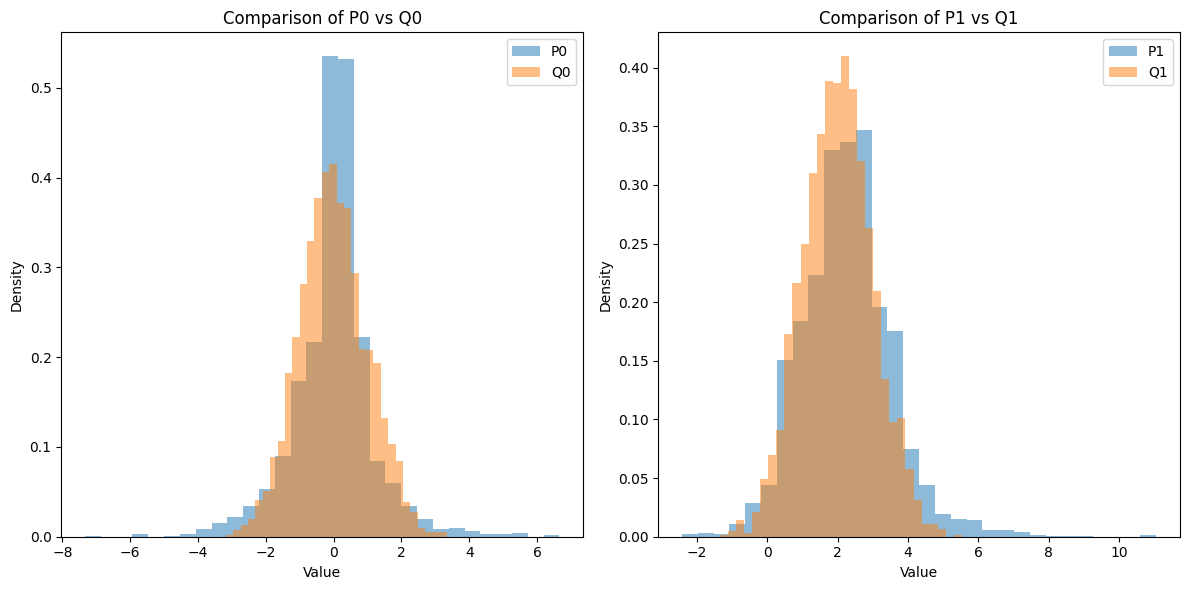

In [ ]:
nrep = 10 # for equivalence testing
n_tr = 500
n_p = 250
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## when training size = 1000, but introducing intrumental / prognostic / spurious variables

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 1.8882, loss1 1.9554, loss2 0.1344
Epoch 100: loss 1.3453, loss1 2.7498, loss2 2.8091
Epoch 200: loss 1.3992, loss1 2.7676, loss2 2.7368
Epoch 300: loss 1.3703, loss1 2.7560, loss2 2.7715
Epoch 400: loss 1.3699, loss1 2.7672, loss2 2.7947
Epoch 500: loss 1.3823, loss1 2.7884, loss2 2.8122
Epoch 1: loss 2.3245,	loss_y 1.5849, 1.6012, 0.0326,	loss_eta 0.7395, 0.7742, 0.0693
Epoch 100: loss 1.3226,	loss_y 0.7410, 1.9212, 2.3604,	loss_eta 0.5816, 1.2209, 1.2786
Epoch 200: loss 1.3122,	loss_y 0.6568, 1.1806, 1.0475,	loss_eta 0.6554, 0.9461, 0.5814
Epoch 300: loss 2.1315,	loss_y 1.2457, 2.3595, 2.2275,	loss_eta 0.8858, 1.2061, 0.6407
Epoch 400: loss 1.6631,	loss_y 0.9073, 2.0309, 2.2471,	loss_eta 0.7557, 0.8029, 0.0943
Epoch 500: loss 1.7872,	loss_y 1.0814, 1.4493, 0.7357,	loss_eta 0.7058, 0.8403, 0.2690
Epoch 600: loss 1.5819,	loss_y 0.9191, 2.2784, 2.7187,	loss_eta 0.6628, 1.0252, 0.7247
Epoch 700: loss 1.4942,	loss_y 0.7767, 2.3580, 3.1626,	loss_eta 0.7176, 1.0905, 0.7459
Ep

 10%|█         | 1/10 [00:13<02:00, 13.36s/it]

Epoch 1000: loss 1.2582,	loss_y 0.5746, 1.1406, 1.1321,	loss_eta 0.6836, 0.9093, 0.4514
Epoch 1: loss 1.8867, loss1 1.9779, loss2 0.1824
Epoch 100: loss 1.4343, loss1 2.7969, loss2 2.7253
Epoch 200: loss 1.4133, loss1 2.7938, loss2 2.7611
Epoch 300: loss 1.3952, loss1 2.7568, loss2 2.7231
Epoch 400: loss 1.3627, loss1 2.7185, loss2 2.7116
Epoch 500: loss 1.4145, loss1 2.7993, loss2 2.7696
Epoch 1: loss 2.2604,	loss_y 1.4853, 1.5050, 0.0395,	loss_eta 0.7751, 0.8192, 0.0882
Epoch 100: loss 1.3450,	loss_y 0.7061, 1.8946, 2.3769,	loss_eta 0.6389, 1.3052, 1.3325
Epoch 200: loss 1.3343,	loss_y 0.7058, 0.9780, 0.5445,	loss_eta 0.6286, 0.8684, 0.4797
Epoch 300: loss 1.7560,	loss_y 1.1479, 2.2505, 2.2053,	loss_eta 0.6081, 1.1890, 1.1617
Epoch 400: loss 1.6337,	loss_y 0.8875, 1.6574, 1.5398,	loss_eta 0.7462, 1.1932, 0.8941
Epoch 500: loss 1.6426,	loss_y 0.9118, 1.7841, 1.7446,	loss_eta 0.7308, 0.8057, 0.1497
Epoch 600: loss 1.4869,	loss_y 0.7728, 1.2606, 0.9757,	loss_eta 0.7141, 0.8581, 0.2879
E

 20%|██        | 2/10 [00:28<01:54, 14.36s/it]

Epoch 1000: loss 1.5001,	loss_y 0.7950, 1.8297, 2.0692,	loss_eta 0.7050, 0.7916, 0.1732
Epoch 1: loss 1.8919, loss1 1.9777, loss2 0.1716
Epoch 100: loss 1.3973, loss1 2.7690, loss2 2.7434
Epoch 200: loss 1.3891, loss1 2.7905, loss2 2.8027
Epoch 300: loss 1.3605, loss1 2.7522, loss2 2.7835
Epoch 400: loss 1.4029, loss1 2.7904, loss2 2.7749
Epoch 500: loss 1.3708, loss1 2.7819, loss2 2.8221
Epoch 1: loss 2.2899,	loss_y 1.5390, 1.5599, 0.0419,	loss_eta 0.7510, 0.7807, 0.0595
Epoch 100: loss 1.2219,	loss_y 0.6775, 1.9178, 2.4806,	loss_eta 0.5444, 1.0677, 1.0466
Epoch 200: loss 1.2429,	loss_y 0.6017, 1.1854, 1.1674,	loss_eta 0.6412, 1.1483, 1.0142
Epoch 300: loss 1.6030,	loss_y 1.0105, 2.1060, 2.1910,	loss_eta 0.5925, 0.9443, 0.7035
Epoch 400: loss 1.1941,	loss_y 0.6219, 1.5305, 1.8173,	loss_eta 0.5722, 0.9727, 0.8009
Epoch 500: loss 1.4716,	loss_y 0.8697, 1.4239, 1.1084,	loss_eta 0.6019, 1.0354, 0.8669
Epoch 600: loss 1.4426,	loss_y 0.8301, 1.0876, 0.5150,	loss_eta 0.6125, 0.9841, 0.7433
E

 30%|███       | 3/10 [00:42<01:40, 14.32s/it]

Epoch 1000: loss 1.6561,	loss_y 0.8902, 2.1223, 2.4641,	loss_eta 0.7659, 0.7944, 0.0569
Epoch 1: loss 1.8823, loss1 1.9917, loss2 0.2188
Epoch 100: loss 1.4270, loss1 2.8199, loss2 2.7859
Epoch 200: loss 1.3902, loss1 2.7710, loss2 2.7616
Epoch 300: loss 1.4163, loss1 2.8179, loss2 2.8032
Epoch 400: loss 1.4278, loss1 2.8109, loss2 2.7663
Epoch 500: loss 1.3947, loss1 2.7658, loss2 2.7423
Epoch 1: loss 2.3438,	loss_y 1.5702, 1.5971, 0.0538,	loss_eta 0.7736, 0.8054, 0.0637
Epoch 100: loss 1.4064,	loss_y 0.7792, 2.1015, 2.6446,	loss_eta 0.6272, 1.2508, 1.2473
Epoch 200: loss 1.2917,	loss_y 0.5715, 0.8566, 0.5700,	loss_eta 0.7201, 0.8888, 0.3373
Epoch 300: loss 1.3057,	loss_y 0.5864, 1.4747, 1.7767,	loss_eta 0.7194, 0.8919, 0.3451
Epoch 400: loss 1.5390,	loss_y 0.7829, 1.8132, 2.0606,	loss_eta 0.7562, 0.8556, 0.1988
Epoch 500: loss 1.3142,	loss_y 0.6831, 1.6698, 1.9734,	loss_eta 0.6310, 0.8905, 0.5188
Epoch 600: loss 1.4751,	loss_y 0.9160, 2.1147, 2.3975,	loss_eta 0.5591, 1.1718, 1.2253
E

 40%|████      | 4/10 [00:56<01:25, 14.24s/it]

Epoch 1000: loss 1.3681,	loss_y 0.7483, 1.7292, 1.9619,	loss_eta 0.6198, 1.1906, 1.1416
Epoch 1: loss 1.8425, loss1 1.9409, loss2 0.1967
Epoch 100: loss 1.3450, loss1 2.7039, loss2 2.7176
Epoch 200: loss 1.3396, loss1 2.6919, loss2 2.7046
Epoch 300: loss 1.3861, loss1 2.7067, loss2 2.6412
Epoch 400: loss 1.3677, loss1 2.7179, loss2 2.7002
Epoch 500: loss 1.3633, loss1 2.7594, loss2 2.7923
Epoch 1: loss 2.1980,	loss_y 1.4574, 1.4680, 0.0212,	loss_eta 0.7406, 0.7873, 0.0934
Epoch 100: loss 1.3431,	loss_y 0.7456, 1.9018, 2.3124,	loss_eta 0.5975, 1.0278, 0.8606
Epoch 200: loss 1.5688,	loss_y 0.7992, 1.2262, 0.8540,	loss_eta 0.7696, 1.1387, 0.7382
Epoch 300: loss 1.4642,	loss_y 0.6716, 1.4527, 1.5622,	loss_eta 0.7925, 1.1084, 0.6317
Epoch 400: loss 1.3491,	loss_y 0.5984, 1.3209, 1.4449,	loss_eta 0.7506, 0.8309, 0.1606
Epoch 500: loss 1.1664,	loss_y 0.5371, 1.0247, 0.9752,	loss_eta 0.6293, 0.9170, 0.5754
Epoch 600: loss 1.2198,	loss_y 0.5529, 0.9356, 0.7654,	loss_eta 0.6669, 1.2937, 1.2535
E

 50%|█████     | 5/10 [01:09<01:08, 13.70s/it]

Epoch 1000: loss 1.4694,	loss_y 0.8479, 1.2464, 0.7969,	loss_eta 0.6215, 0.8762, 0.5094
Epoch 1: loss 1.8761, loss1 1.9688, loss2 0.1856
Epoch 100: loss 1.3600, loss1 2.7245, loss2 2.7289
Epoch 200: loss 1.4004, loss1 2.7997, loss2 2.7987
Epoch 300: loss 1.3842, loss1 2.7648, loss2 2.7612
Epoch 400: loss 1.3378, loss1 2.7438, loss2 2.8120
Epoch 500: loss 1.3586, loss1 2.7584, loss2 2.7996
Epoch 1: loss 2.3320,	loss_y 1.5791, 1.5939, 0.0295,	loss_eta 0.7529, 0.7877, 0.0696
Epoch 100: loss 1.1746,	loss_y 0.6380, 1.7806, 2.2853,	loss_eta 0.5366, 1.1125, 1.1516
Epoch 200: loss 1.2822,	loss_y 0.7045, 1.1366, 0.8643,	loss_eta 0.5777, 0.9679, 0.7803
Epoch 300: loss 1.7735,	loss_y 1.0511, 2.2293, 2.3563,	loss_eta 0.7223, 1.0765, 0.7084
Epoch 400: loss 1.5086,	loss_y 0.7620, 1.8963, 2.2687,	loss_eta 0.7466, 1.1215, 0.7497
Epoch 500: loss 1.3788,	loss_y 0.7155, 1.0514, 0.6719,	loss_eta 0.6633, 0.8321, 0.3374
Epoch 600: loss 1.3217,	loss_y 0.6499, 1.6055, 1.9113,	loss_eta 0.6718, 0.8002, 0.2568
E

 60%|██████    | 6/10 [01:22<00:53, 13.47s/it]

Epoch 1000: loss 1.2948,	loss_y 0.6699, 1.2678, 1.1958,	loss_eta 0.6249, 1.4508, 1.6518
Epoch 1: loss 1.9019, loss1 1.9762, loss2 0.1487
Epoch 100: loss 1.3938, loss1 2.7747, loss2 2.7618
Epoch 200: loss 1.4041, loss1 2.8030, loss2 2.7978
Epoch 300: loss 1.3499, loss1 2.7824, loss2 2.8650
Epoch 400: loss 1.3957, loss1 2.7500, loss2 2.7087
Epoch 500: loss 1.4315, loss1 2.8032, loss2 2.7433
Epoch 1: loss 2.2506,	loss_y 1.4827, 1.5019, 0.0384,	loss_eta 0.7679, 0.8146, 0.0933
Epoch 100: loss 1.2196,	loss_y 0.6666, 1.8061, 2.2790,	loss_eta 0.5530, 1.1657, 1.2253
Epoch 200: loss 1.3527,	loss_y 0.6110, 1.0074, 0.7928,	loss_eta 0.7418, 0.8669, 0.2503
Epoch 300: loss 1.1835,	loss_y 0.5319, 1.2486, 1.4334,	loss_eta 0.6516, 0.8599, 0.4167
Epoch 400: loss 1.2583,	loss_y 0.5826, 1.4305, 1.6959,	loss_eta 0.6757, 0.8842, 0.4169
Epoch 500: loss 1.2390,	loss_y 0.5799, 1.5478, 1.9359,	loss_eta 0.6591, 0.8423, 0.3662
Epoch 600: loss 1.3527,	loss_y 0.7066, 1.4444, 1.4755,	loss_eta 0.6461, 0.9344, 0.5767
E

 70%|███████   | 7/10 [01:35<00:40, 13.43s/it]

Epoch 1000: loss 1.1753,	loss_y 0.6017, 1.3608, 1.5182,	loss_eta 0.5736, 1.0550, 0.9628
Epoch 1: loss 1.8830, loss1 1.9753, loss2 0.1847
Epoch 100: loss 1.4059, loss1 2.8098, loss2 2.8078
Epoch 200: loss 1.4000, loss1 2.8031, loss2 2.8061
Epoch 300: loss 1.4176, loss1 2.7711, loss2 2.7070
Epoch 400: loss 1.4186, loss1 2.7988, loss2 2.7605
Epoch 500: loss 1.3466, loss1 2.7178, loss2 2.7424
Epoch 1: loss 2.2683,	loss_y 1.5141, 1.5245, 0.0207,	loss_eta 0.7542, 0.7871, 0.0657
Epoch 100: loss 1.3040,	loss_y 0.6634, 1.1651, 1.0035,	loss_eta 0.6406, 1.1783, 1.0752
Epoch 200: loss 1.4503,	loss_y 0.6720, 1.5455, 1.7470,	loss_eta 0.7783, 1.0418, 0.5270
Epoch 300: loss 1.3952,	loss_y 0.6560, 1.0789, 0.8458,	loss_eta 0.7392, 0.8554, 0.2323
Epoch 400: loss 1.2843,	loss_y 0.6912, 1.1167, 0.8512,	loss_eta 0.5932, 0.8808, 0.5752
Epoch 500: loss 1.2929,	loss_y 0.7208, 1.2099, 0.9783,	loss_eta 0.5722, 1.3944, 1.6444
Epoch 600: loss 1.2338,	loss_y 0.6485, 1.6363, 1.9756,	loss_eta 0.5853, 1.3786, 1.5866
E

 80%|████████  | 8/10 [01:49<00:26, 13.37s/it]

Epoch 1000: loss 1.2543,	loss_y 0.5908, 1.2758, 1.3699,	loss_eta 0.6635, 1.8696, 2.4122
Epoch 1: loss 1.8682, loss1 1.9489, loss2 0.1613
Epoch 100: loss 1.3682, loss1 2.6797, loss2 2.6230
Epoch 200: loss 1.4016, loss1 2.7525, loss2 2.7018
Epoch 300: loss 1.3865, loss1 2.7207, loss2 2.6685
Epoch 400: loss 1.4215, loss1 2.7348, loss2 2.6267
Epoch 500: loss 1.3419, loss1 2.7281, loss2 2.7725
Epoch 1: loss 2.2977,	loss_y 1.5158, 1.5410, 0.0503,	loss_eta 0.7819, 0.8178, 0.0718
Epoch 100: loss 1.2169,	loss_y 0.6709, 1.8224, 2.3030,	loss_eta 0.5460, 1.2778, 1.4637
Epoch 200: loss 1.5549,	loss_y 0.8207, 1.1373, 0.6332,	loss_eta 0.7341, 0.9246, 0.3808
Epoch 300: loss 1.3778,	loss_y 0.7490, 1.9543, 2.4105,	loss_eta 0.6288, 0.8947, 0.5317
Epoch 400: loss 1.2184,	loss_y 0.6317, 1.4896, 1.7158,	loss_eta 0.5867, 1.2894, 1.4053
Epoch 500: loss 1.2787,	loss_y 0.5733, 1.1588, 1.1709,	loss_eta 0.7053, 1.1685, 0.9263
Epoch 600: loss 1.2741,	loss_y 0.5830, 1.0978, 1.0296,	loss_eta 0.6911, 0.8201, 0.2579
E

 90%|█████████ | 9/10 [02:02<00:13, 13.36s/it]

Epoch 1000: loss 1.1581,	loss_y 0.6194, 1.5871, 1.9354,	loss_eta 0.5387, 1.1125, 1.1476
Epoch 1: loss 1.8432, loss1 1.9161, loss2 0.1458
Epoch 100: loss 1.3493, loss1 2.6916, loss2 2.6846
Epoch 200: loss 1.3951, loss1 2.6851, loss2 2.5800
Epoch 300: loss 1.3702, loss1 2.7077, loss2 2.6749
Epoch 400: loss 1.3802, loss1 2.7303, loss2 2.7001
Epoch 500: loss 1.3189, loss1 2.6659, loss2 2.6940
Epoch 1: loss 2.3281,	loss_y 1.5406, 1.5580, 0.0348,	loss_eta 0.7875, 0.8350, 0.0950
Epoch 100: loss 1.1592,	loss_y 0.5861, 1.2761, 1.3799,	loss_eta 0.5731, 1.0270, 0.9078
Epoch 200: loss 1.3159,	loss_y 0.6266, 1.4247, 1.5963,	loss_eta 0.6893, 0.8491, 0.3196
Epoch 300: loss 1.2932,	loss_y 0.5317, 1.0696, 1.0759,	loss_eta 0.7615, 0.9120, 0.3010
Epoch 400: loss 1.2072,	loss_y 0.5267, 0.9877, 0.9220,	loss_eta 0.6805, 0.9073, 0.4537
Epoch 500: loss 1.3636,	loss_y 0.6422, 1.0970, 0.9097,	loss_eta 0.7214, 0.8224, 0.2020
Epoch 600: loss 1.2931,	loss_y 0.5747, 1.4041, 1.6588,	loss_eta 0.7184, 0.8405, 0.2442
E

100%|██████████| 10/10 [02:15<00:00, 13.57s/it]

Epoch 1000: loss 1.3968,	loss_y 0.7984, 1.4711, 1.3455,	loss_eta 0.5984, 1.3969, 1.5970


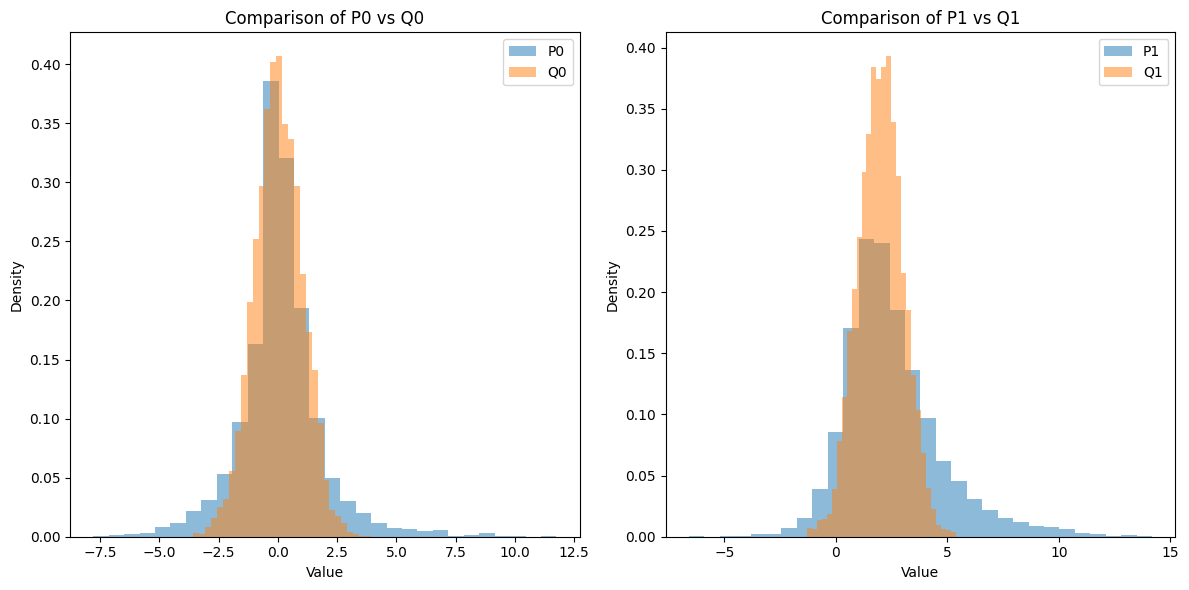

In [ ]:
nrep = 10 # for equivalence testing
n_tr = 1000
n_p = 500
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()